# Introduction to Bamboo

*March 2021*

Bamboo is Python package for modelling the cooling systems of liquid rocket engines. 

Most of its functionality revolves around the bamboo.main.Engine class. Full documentation is available at https://cuspaceflight.github.io/bamboo/.

## *Simple Engine Example*

We will start with an example of creating an Engine. 

To create an Engine object, we need to first create three sub-objects: 
- A <b>PerfectGas</b> object
- A <b>ChamberConditions</b> object
- A <b>Nozzle</b> object

We will first import bamboo and any other modules we need, and will then specify the operating conditions for our engine.

In [1]:
import bamboo as bam
import numpy as np
import matplotlib.pyplot as plt
import thermo

'''Chosen operating points'''
mdot = 4.757        #Mass flow rate (kg/s)
p_amb = 1.01325e5   #Ambient pressure (Pa). 
pc = 10e5           #Chamber pressure (Pa)

'''From ProPEP 3 I got the following data on my exhaust gas'''
gamma = 1.264               #Ratio of specific heats cp/cv (used to specify our PerfectGas object)
molecular_weight = 21.627   #Molecular weight of the exhaust gas (kg/kmol) (used to specify our PerfectGas object)
Tc = 2458.89                #Chamber temperature (K) - obtained from ProPEP 3

### PerfectGas and ChamberConditions

To define our perfect gas, we must specify two of its properties. See the documentation available options. As of writing, the available keyword arguments are 'gamma', 'molecular_weight' and 'cp'.

To define our ChamberConditions, we need the mass flow rate 'mdot', the chamber stagnation pressure 'p0', and the chamber stagnation temperature 'T0'.

In [2]:
perfect_gas = bam.PerfectGas(gamma = gamma, molecular_weight = molecular_weight)
chamber = bam.ChamberConditions(pc, Tc, mdot)

### Nozzle

To define the Nozzle, we have two options. 
- Directly specify the throat and exit area (At and Ae respectively)
- Use the Nozzle.from_engine_components() method, which will select At to just choke the nozzle, and Ae to match a given exit pressure, 'p_amb'. 

(The 'WARNING: Area ratio is outside the range of the Rao [...] data' message is not problematic. By default the program will try to create a Rao bell nozzle, but the data for such nozzles is unavailable for very large or small area ratios. In either of these cases, <b> the software simply uses an exit angle of 15 degrees</b>).

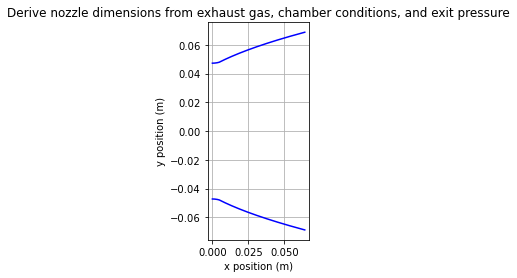

Rao type nozzle (length fraction = 0.8). 
Length = 0.06421000613621163 m 
Throat area = 0.007000596639641742 m^2 
Exit area = 0.014832425713316083 m^2 
Area ratio = 2.1187373700872354 
Rao inflection angle = 14.999999999999998 deg 
Rao exit angle = 14.999 deg


In [3]:
#Directly specifying At and Ae

'''
chosen_At = 0.007
chosen_Ae = 0.05

nozzle = bam.Nozzle(chosen_At, chosen_Ae, type = "rao", length_fraction = 0.8)
nozzle.plot_nozzle()
plt.title("Directly specified throat and exit area")
plt.show()
'''

#Deriving Ae and At from the operating conditions and exit pressure
nozzle = bam.Nozzle.from_engine_components(perfect_gas, chamber, p_amb)
nozzle.plot_nozzle()
plt.title("Derive nozzle dimensions from exhaust gas, chamber conditions, and exit pressure")
plt.show()

#Print the nozzle parameters
print(nozzle)

### Creating the Engine object

We can now create the Engine object with relative ease:

In [4]:
engine = bam.Engine(perfect_gas, chamber, nozzle)

We can now get some properties of the Engine:

(note that almost all calculations made with the engine assume isentropic, 1-dimensional, perfect gas relations. Hence, the results may be different to those calculated using reacting flow e.g. from NASA's CEA, or ProPEP).

In [5]:
print(f"Sea level thrust = {engine.thrust(1e5)/1000} kN")
print(f"Sea level Isp = {engine.isp(1e5)} s")

print(f"\nThroat pressure = {engine.p(0)/1e5} bar")
print(f"Throat temperature = {engine.T(0) - 273.15} °C")
print(f"Throat Mach number = {engine.M(0)}")

print(f"\nExit pressure = {engine.p(nozzle.length)/1e5} bar")
print(f"Exit temperature = {engine.T(nozzle.length) - 273.15} °C")
print(f"Exit Mach number = {engine.M(nozzle.length)}")

Sea level thrust = 8.843291394292795 kN
Sea level Isp = 189.56585265605534 s

Throat pressure = 5.523188113751419 bar
Throat temperature = 1899.0143109540631 °C
Throat Mach number = 1.0

Exit pressure = 1.013249999999998 bar
Exit temperature = 1251.1565550494934 °C
Exit Mach number = 2.1551917585508087


## *Running a cooling system analysis*

To run a cooling system analysis, we need to specify the following:
- Engine geometry, using **Engine.add_geometry()**.
- Transport properties of the exhaust gas (and the coolant if applicable), using the **TransportProperties** class.
- Cooling jacket specifications (if applicable), using **Engine.add_cooling_jacket()**.
- Any ablative* liners, using **Engine.add_ablative()**.
- Material properties of the engine wall and any ablatives, using the **Material** class.

*Note that a more appropriate term might be 'refractory'. The actual ablation of 'ablatives' is not modelled right now, so they simply act as thermal insulators.

### Exhaust gas transport properties

In [6]:
#We'll set up a very crude exhaust gas model using thermo.
thermo_gas = thermo.mixture.Mixture(['N2', 'H2O', 'CO2'], zs = [1, 0.2, 0.2])            
gas_transport = bam.cooling.TransportProperties(model = "thermo", thermo_object = thermo_gas, force_phase = 'g')

#Add it to the engine
engine.add_exhaust_transport(gas_transport)

### Engine geometry


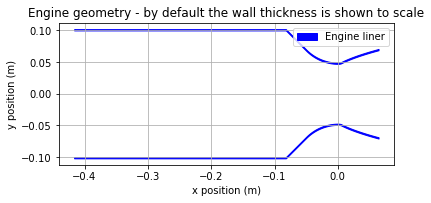

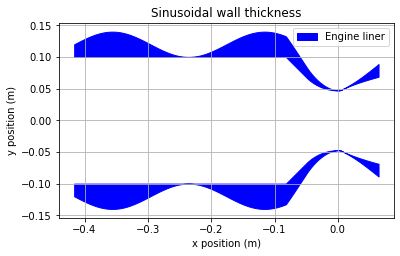

In [7]:
'''Specify the geometry of the engine'''
Ac = np.pi*0.1**2               #Chamber cross-sectional area (m^2) - we'll use a 0.1 m radius.
L_star = 1.5                    #Use the idea of L*: L_star = Volume_c/Area_t
chamber_length = L_star*nozzle.At/Ac
wall_thickness = 2e-3           #Thickness of engine wall (m)

'''Add the geometry to the engine and plot it'''
engine.add_geometry(chamber_length, Ac, wall_thickness)
engine.plot_geometry()
plt.title("Engine geometry - by default the wall thickness is shown to scale")

'''If we want we can specify a variable wall thicknesses'''
#Make an array of equally spaced thickness datapoints
sinusoidal_thickness = 0.02 + 0.02*np.sin(np.linspace(0, 4*np.pi, 100)) 

#The program will stretch the thickness array across the whole engine
engine.add_geometry(chamber_length, Ac, sinusoidal_thickness)       
engine.plot_geometry()
plt.title("Sinusoidal wall thickness")
plt.show()

#(Add the normal geometry back for later)
engine.add_geometry(chamber_length, Ac, wall_thickness)

### Cooling jacket

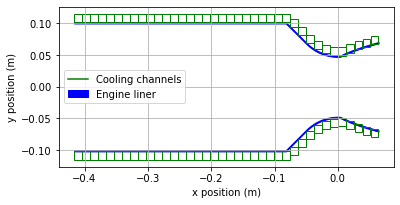

In [8]:
'''Choose the transport properties model for our coolant'''
#We'll use the 'thermo' module to get transport properties for our coolant.
#As an alternative, you could also use the 'CoolProp' module.
thermo_coolant = thermo.chemical.Chemical('isopropanol')
coolant_transport = bam.cooling.TransportProperties(model = "thermo", thermo_object = thermo_coolant, force_phase = 'l')

'''Cooling jacket properties'''
inlet_T = 298.15  #Coolant inlet temperature (K)
inlet_p0 = 20e5   #Coolant inlet stagnation pressure (bar)
OF_ratio = 3.5    #Oxidiser/fuel mass ratio
mdot_coolant = mdot/(OF_ratio + 1) #Mass flow rate of coolant
wall_material = bam.materials.CopperC700

'''Add a spiral cooling jacket to the engine'''
#See the documentation for a full list of cooling jacket options
#You can also alternatively use vertical channels, or have the cooling jacket on present over a finite range of the engine.
engine.add_cooling_jacket(wall_material, 
                               inlet_T, 
                               inlet_p0, 
                               coolant_transport, 
                               mdot_coolant, 
                               configuration = "spiral", 
                               channel_shape = "semi-circle", 
                               channel_width = 0.020)


#We can see a rough representation of the cooling jacket on the geometry plot 
engine.plot_geometry()
plt.show()

### Ablative*
*note that right now, ablatives are only modelled as thermal insulators

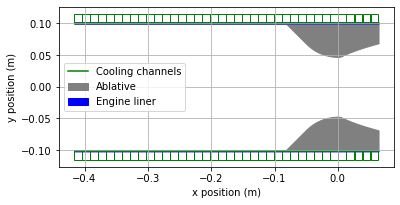

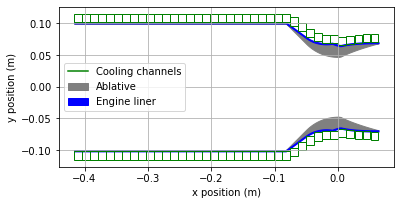

In [9]:
#Choose the material properties for our ablative
ablative_material = bam.materials.Graphite

#Note the 'regression_rate' value doesn't affect anything right now
#By default the program will use an ablative along the whole engine,
#and will fill up the gap between the nozzle contour and chamber radius with ablative
engine.add_ablative(ablative_material,
                    wall_material, 
                    regression_rate = 0.0033e-3)

engine.plot_geometry()

#We can also specify the thickness (which can be variable, just like for Engine.add_geometry()), 
#and the range of x values over which we want the ablative to be present

#In this example we make the ablative only present in the nozzle, and make it thickest around the middle.
engine.add_ablative(ablative_material,
                    wall_material, 
                    regression_rate = 0.0033e-3,
                    xs = [engine.geometry.x_chamber_end, engine.geometry.x_max],
                    ablative_thickness = [0.0, 0.02, 0.0])

engine.plot_geometry()
plt.show()

#(Replace the ablative with the 1st version - this is the one we'll analyse later)
engine.add_ablative(ablative_material,
                    wall_material, 
                    regression_rate = 0.0033e-3)


## Running a steady state heating simulation

We can now run a steady state heating simulation with relative ease. This uses the idea of thermal circuits to find the heat transfer through the wall, and temperatures at each point.

In [10]:
#Run the heating analysis - see the documentation for details on the various arguments.
#We'll try using the two different 'h_gas_model' options, so we can compare them.
data_hgas1 = engine.steady_heating_analysis(h_gas_model = '1')
data_hgas3 = engine.steady_heating_analysis(h_gas_model = '3')

#Print of the keys so we can see what data is available
print(data_hgas1.keys())

Exported JSON data to 'heating_output.json'
Exported JSON data to 'heating_output.json'
dict_keys(['x', 'T_wall_inner', 'T_wall_outer', 'T_coolant', 'T_gas', 'q_dot', 'h_gas', 'h_coolant', 'p_coolant', 'boil_off_position'])


Note that the 'x' position array runs 'in reverse' - it starts with index [0] at the nozzle exit, and moves towards the chamber. The data in all the other arrays corresponds to the x positions given in the 'x' array.

So e.g. `data_hgas1['T_gas'][0]` is the exhaust gas temperature at nozzle exit, and `data_hgas1['T_gas'][-1]` is the exhaust gas temperature in the chamber.

Final x position = -0.4163781058592353
Coolant exit temperature with h_gas_model = '1': 396.0721179787813 K
Coolant exit temperature with h_gas_model = '3': 388.3356288298858 K


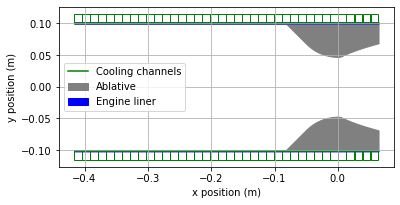

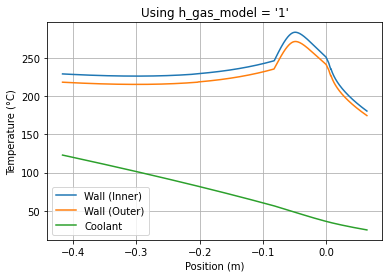

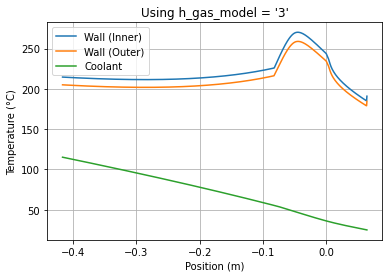

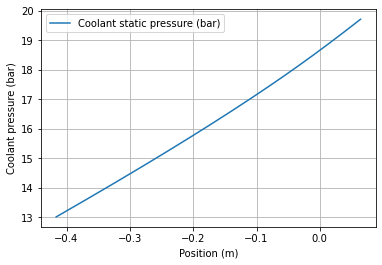

In [11]:
#Print the final coolant temperatures in each case:
print(f"Final x position = {data_hgas1['x'][-1]}") 
print(f"Coolant exit temperature with h_gas_model = '1': {data_hgas1['T_coolant'][-1]} K")
print(f"Coolant exit temperature with h_gas_model = '3': {data_hgas3['T_coolant'][-1]} K")

#Plot the geometry again so we can compare it
engine.plot_geometry()

#Use the built in plotting functions to quickly generate some plots
bam.plot.plot_temperatures(data_hgas1)
plt.title("Using h_gas_model = '1'")

bam.plot.plot_temperatures(data_hgas3)
plt.title("Using h_gas_model = '3'")

bam.plot.plot_jacket_pressure(data_hgas1)